# Introduction

### Libraries

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy.linalg import sqrtm
np.set_printoptions(suppress=True)      # to avoid scientific notation

### Data preparation

In [53]:
# cac40.csv contains adjusted close prices from 2023 April to 2025 June 
cac40 = pd.read_csv('cac40.csv',index_col="Date")
cac40 = cac40.loc['2024-01-01':]
cac40_evolution = cac40['^FCHI']/cac40['^FCHI'].iloc[0]

returns = cac40.drop(columns=['^FCHI']).pct_change().dropna()
tickers = returns.columns
T,N = returns.shape

# Optimisation Problem

## Weights initialisation

In [61]:
# Initialisation window: Jan 22 - Dec 24
returns_init = returns.loc[:'2025-01-01'].to_numpy()
w = cvx.Variable(N)
portfolio_value = cvx.cumprod(1 + returns_init@w )

# Expected log-growth
g = cvx.mean( cvx.log( 1 + returns_init@w ) , axis=0)

# Volatility as variance 
variance = cvx.var(returns_init@w)

# Problem formulation
objective = cvx.Maximize(g)
constraints = [w>=0,w<=0.2, cvx.sum(w)==1,variance<=5e-5]
kelly_opt = cvx.Problem(objective=objective,constraints=constraints)
kelly_opt.solve()
w_0 = np.round(w.value,4)

weights = pd.DataFrame(w_0,index=tickers,columns=['Init weights'])
weights[weights!=0].dropna()

,Init weights
AC.PA,0.2000
BN.PA,0.2000
BVI.PA,0.1123
EL.PA,0.2000
ENGI.PA,0.0055
ORA.PA,0.0186
PUB.PA,0.0272
RNO.PA,0.0791
SAF.PA,0.1331
SAN.PA,0.0242


Portfolio Raw Retrun: 1.304


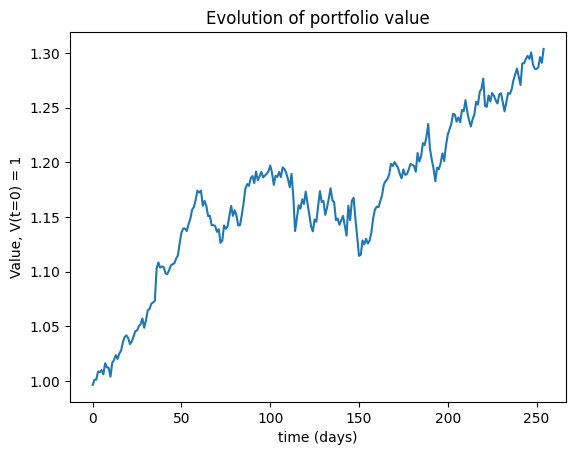

In [63]:
# Overlook of initial portfolio
print(f'Portfolio Raw Retrun: {portfolio_value.value[-1]:.3f}')
plt.plot(portfolio_value.value)
plt.title("Evolution of portfolio value")
plt.xlabel('time (days)')
plt.ylabel('Value, V(t=0) = 1')
plt.show()

## Dynamic re-allocation

# Results analysis

## Influence of the time window

## Influence of the turnover constraint